### https://zhuanlan.zhihu.com/p/176241946

In [1]:
import datetime
import backtrader as bt
import backtrader.indicators as bi
# import backtest
import pandas as pd
import numpy as np
import backtrader.analyzers as btanalyzers
# import math
# import matplotlib.pyplot as plt

In [2]:
import pyfolio as pf
import matplotlib 
%matplotlib inline

d:\code\python\pyfolio\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [3]:
from lutils.stock import LTdxHq

In [4]:
class GridStrategy(bt.Strategy):
    params = (
        ("printlog", True),
        ("top", 12),
        ("buttom", 7),
    )
    
    def __init__(self):
        self.mid = (self.p.top + self.p.buttom)/2.0
        # 百分比区间计算
        #这里多1/2，是因为arange函数是左闭右开区间。
        perc_level = [x for x in np.arange(1 + 0.02 * 5, 1 - 0.02 * 5 - 0.02/2, -0.02)]
        # 价格区间
        # print(self.mid)
        self.price_levels = [self.mid * x for x in perc_level]
        # 记录上一次穿越的网格
        self.last_price_index = None
        # 总手续费
        self.comm = 0.0
 
    def next(self):
        # print(self.last_price_index)
        # 开仓
        if self.last_price_index == None:
            # print("b", len(self.price_levels))
            for i in range(len(self.price_levels)):
                price = self.data.close[0]
                # print("c", i, price, self.price_levels[i][0])
                if self.data.close[0] > self.price_levels[i]:
                    self.last_price_index = i
                    self.order_target_percent(target=i/(len(self.price_levels) - 1))
                    print("a")
                    return
        # 调仓
        else:
            signal = False
            while True:
                upper = None
                lower = None
                if self.last_price_index > 0:
                    upper = self.price_levels[self.last_price_index - 1]
                if self.last_price_index < len(self.price_levels) - 1:
                    lower = self.price_levels[self.last_price_index + 1]
                # 还不是最轻仓，继续涨，再卖一档
                if upper != None and self.data.close > upper:
                    self.last_price_index = self.last_price_index - 1
                    signal = True
                    continue
                # 还不是最重仓，继续跌，再买一档
                if lower != None and self.data.close < lower:
                    self.last_price_index = self.last_price_index + 1
                    signal = True
                    continue
                break
            if signal:
                self.long_short = None
                self.order_target_percent(target=self.last_price_index/(len(self.price_levels) - 1))
 
    # 输出交易记录
    def log(self, txt, dt = None, doprint = False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))
 
    def notify_order(self, order):
        # 有交易提交/被接受，啥也不做
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 交易完成，报告结果
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('执行买入, 价格: %.2f, 成本: %.2f, 手续费 %.2f' % (order.executed.price, order.executed.value, order.executed.comm))
                self.buyprice = order.executed.price
                self.comm += order.executed.comm
            else:
                self.log('执行卖出, 价格: %.2f, 成本: %.2f, 手续费 %.2f' % (order.executed.price, order.executed.value, order.executed.comm))
                self.comm += order.executed.comm
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("交易失败")
        self.order = None
 
    # 输出手续费
    def stop(self):
        self.log("手续费:%.2f 成本比例:%.5f" % (self.comm, self.comm/self.broker.getvalue()))



In [5]:
lt = LTdxHq()

In [6]:
code = '600217' # 510300 000032 300142 603636 600519 688567 600217

In [7]:
df = lt.get_k_data_daily(code, qfq=True)

In [8]:
# df = df['2021-01-01':]

In [9]:
top = df.close.min() * .8
buttom = df.close.max() * 1.1

In [10]:
top

0.784

In [11]:
buttom

16.863000000000003

In [12]:
df.index = pd.to_datetime(df.index)

In [26]:
cerebro = bt.Cerebro(oldtrades=True)

feed = bt.feeds.PandasData(dataname=df, openinterest=None, compression=1, timeframe=bt.TimeFrame.Minutes)
cerebro.adddata(feed)

# top = 4.2
# buttom = 3.5
cerebro.addstrategy(GridStrategy, top=top, buttom=buttom)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Years, data=feed, _name='datareturns')
    
# 小场面1万起始资金
cerebro.broker.setcash(10000.0)

# 手续费万5
cerebro.broker.setcommission(0.0005)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

results = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
a
2001-06-25, 执行买入, 价格: 8.26, 成本: 9003.40, 手续费 4.50
2001-06-26, 执行卖出, 价格: 8.46, 成本: 1015.98, 手续费 0.52
2001-06-27, 执行卖出, 价格: 8.76, 成本: 2040.22, 手续费 1.08
2001-06-28, 执行卖出, 价格: 9.05, 成本: 2023.70, 手续费 1.11
2001-06-29, 执行卖出, 价格: 9.37, 成本: 2007.18, 手续费 1.14
2001-07-02, 执行卖出, 价格: 9.66, 成本: 974.68, 手续费 0.57
2001-07-03, 执行卖出, 价格: 9.86, 成本: 941.64, 手续费 0.56
2001-07-04, 执行买入, 价格: 8.24, 成本: 4070.56, 手续费 2.04
2001-07-05, 执行买入, 价格: 8.07, 成本: 3470.10, 手续费 1.74
2001-07-06, 执行买入, 价格: 7.49, 成本: 3392.97, 手续费 1.70
2007-05-24, 执行卖出, 价格: 8.62, 成本: 1079.86, 手续费 0.59
2007-05-28, 执行买入, 价格: 7.79, 成本: 1168.50, 手续费 0.58
2007-10-08, 执行卖出, 价格: 8.23, 成本: 1085.59, 手续费 0.56
2007-10-09, 执行买入, 价格: 7.63, 成本: 1121.61, 手续费 0.56
2011-04-11, 执行卖出, 价格: 8.48, 成本: 1089.25, 手续费 0.59
2011-04-12, 执行卖出, 价格: 8.23, 成本: 1089.25, 手续费 0.57
2011-04-13, 执行卖出, 价格: 8.72, 成本: 2289.01, 手续费 1.26
2011-04-14, 执行卖出, 价格: 9.03, 成本: 2257.44, 手续费 1.29
2011-04-15, 执行卖出, 价格: 9.32, 成本: 1144.51, 手续费 0.68
2011-04-19, 执行买

In [27]:
# cerebro.plot(
# #     iplot=True,
#     start=datetime.date(2020, 1, 1),
#     end=datetime.date(2022, 8, 4),
#     style='candlestick',
#     barup='red',
#     bardown='green',
# )

In [28]:
# start = "2018-01-01"
# end = "2021-07-05"
# name = ["300etf"]
# code = ["510300"]
# backtest = backtest.BackTest(GridStrategy, start, end, code, name, 100000)
# result = backtest.run()
# # backtest.output()
# print(result)

In [ ]:
strat0 = results[0]

# If no name has been specified, the name is the class name lowercased
tret_analyzer = strat0.analyzers.getbyname('timereturns')
print(tret_analyzer.get_analysis())
tdata_analyzer = strat0.analyzers.getbyname('datareturns')
print(tdata_analyzer.get_analysis())

In [29]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,87.82,2001-07-11,2005-07-18,2007-05-22,1530
1,82.93,2007-05-24,2008-11-04,2011-04-08,1012
2,71.34,2011-04-14,2012-08-15,2014-09-11,891
3,53.65,2017-04-10,2019-01-31,NaT,NaN
4,23.95,2015-01-27,2015-09-18,2015-10-27,196


d:\soft\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 83.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
d:\soft\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 24.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
d:\code\python\pyfolio\pyfolio\timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
Dotcom,0.00%,0.00%,0.00%
Lehman,-0.97%,-5.00%,4.96%
9/11,0.26%,-2.84%,9.95%
US downgrade/European Debt Crisis,-0.81%,-5.04%,2.08%
Fukushima,1.77%,-2.95%,5.03%
US Housing,0.05%,-0.45%,1.53%
EZB IR Event,1.24%,-5.29%,10.08%
Aug07,3.48%,-2.45%,5.06%
Mar08,-1.18%,-5.05%,3.65%
Sept08,-1.12%,-4.97%,4.96%


Top 10 long positions of all time,max
Data0,99.99%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Data0,99.99%


d:\soft\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


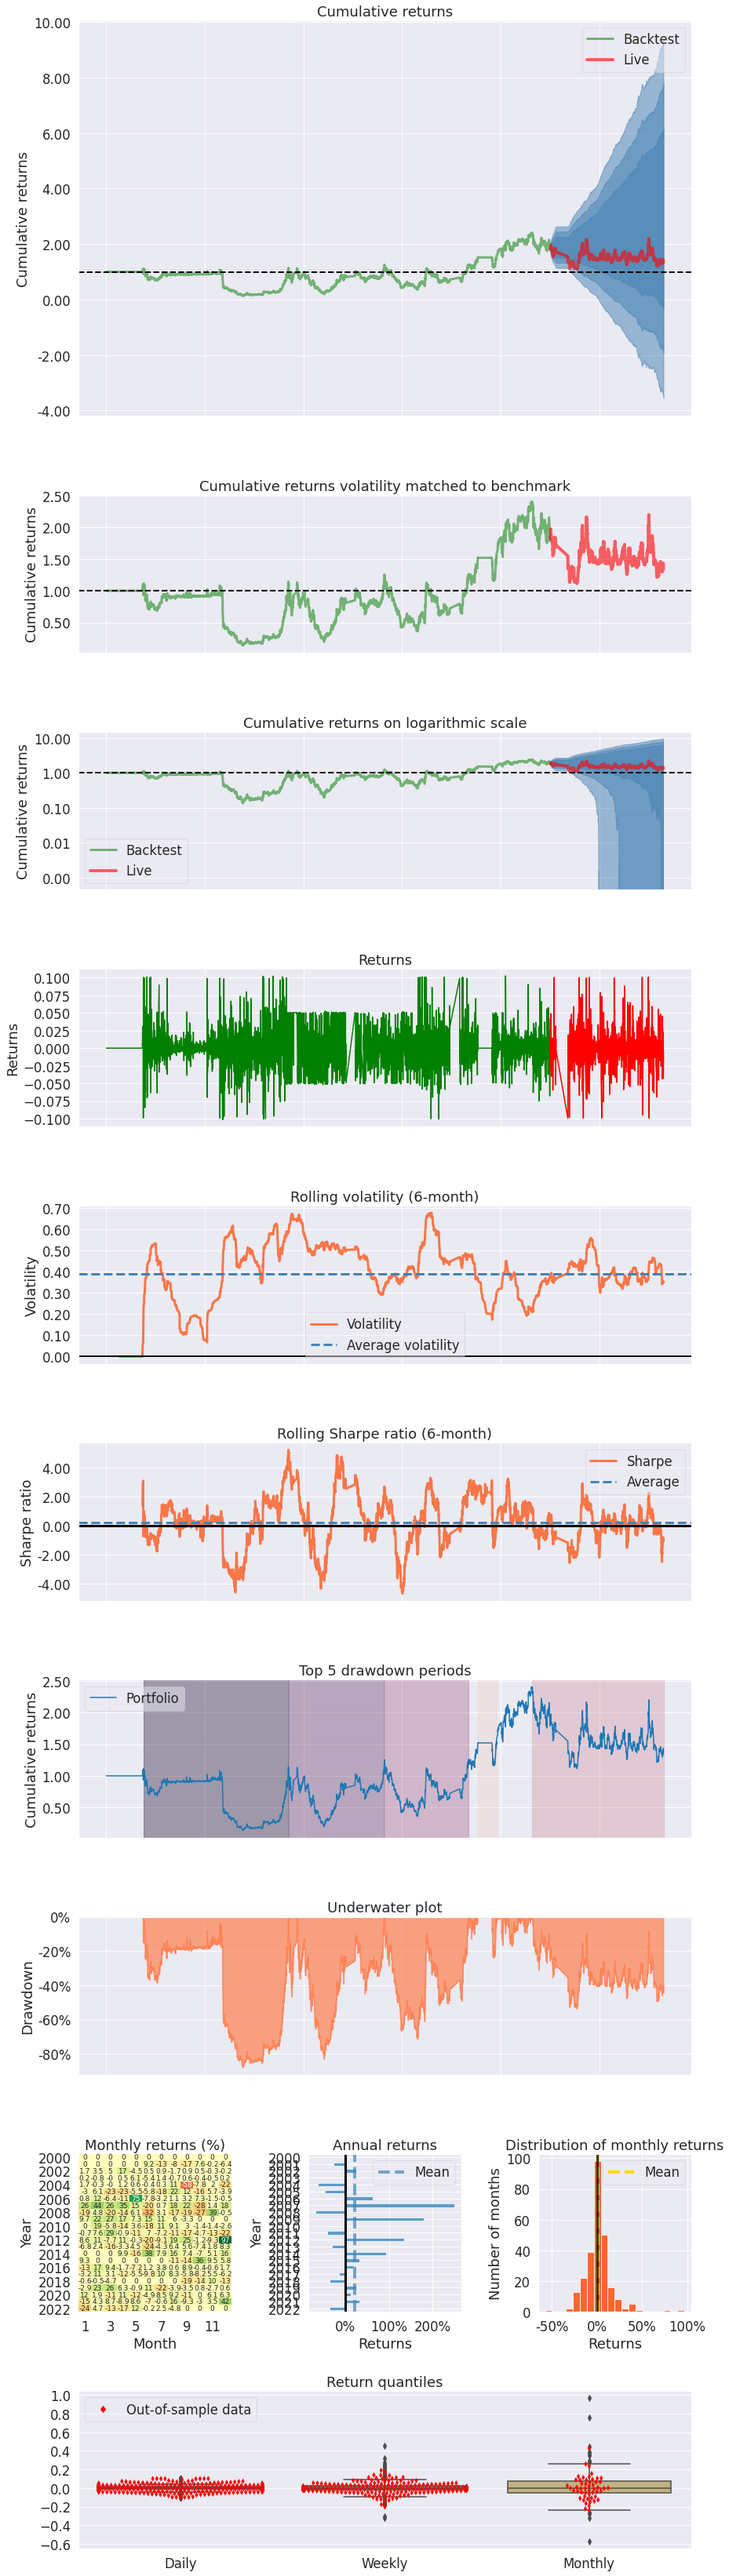

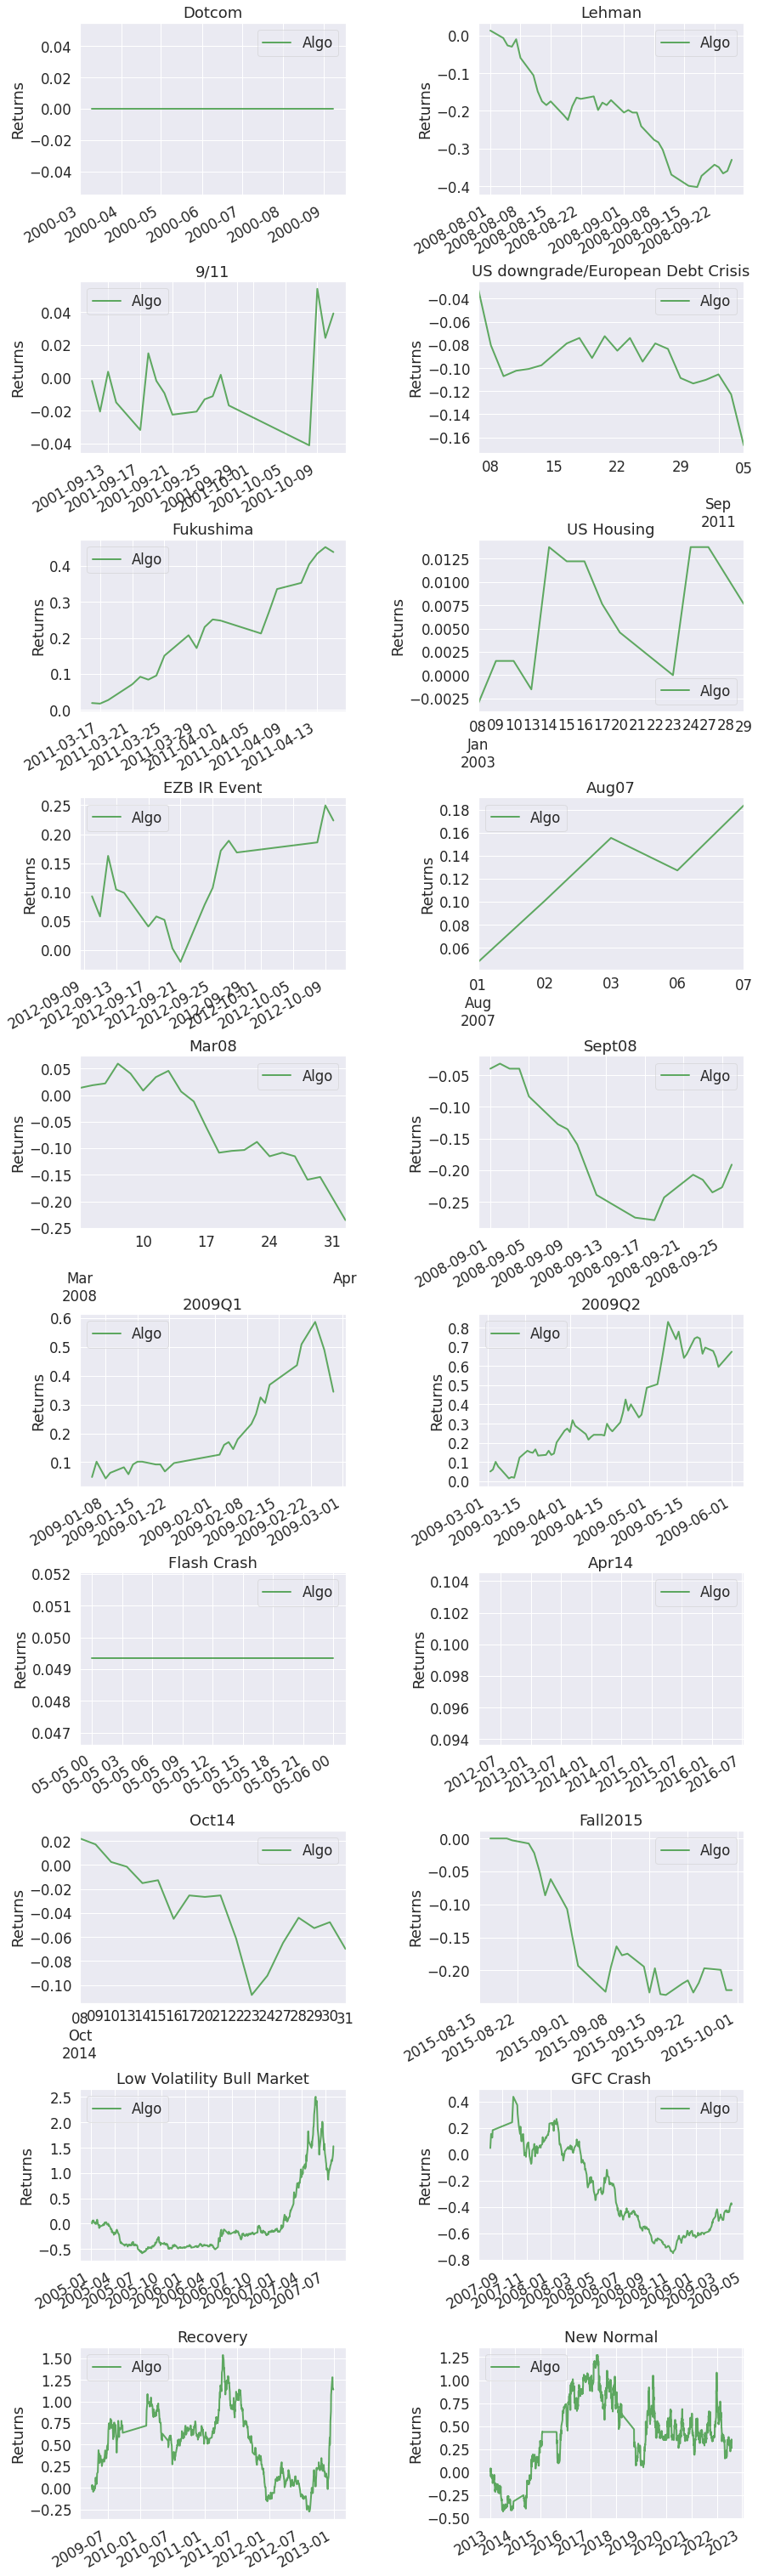

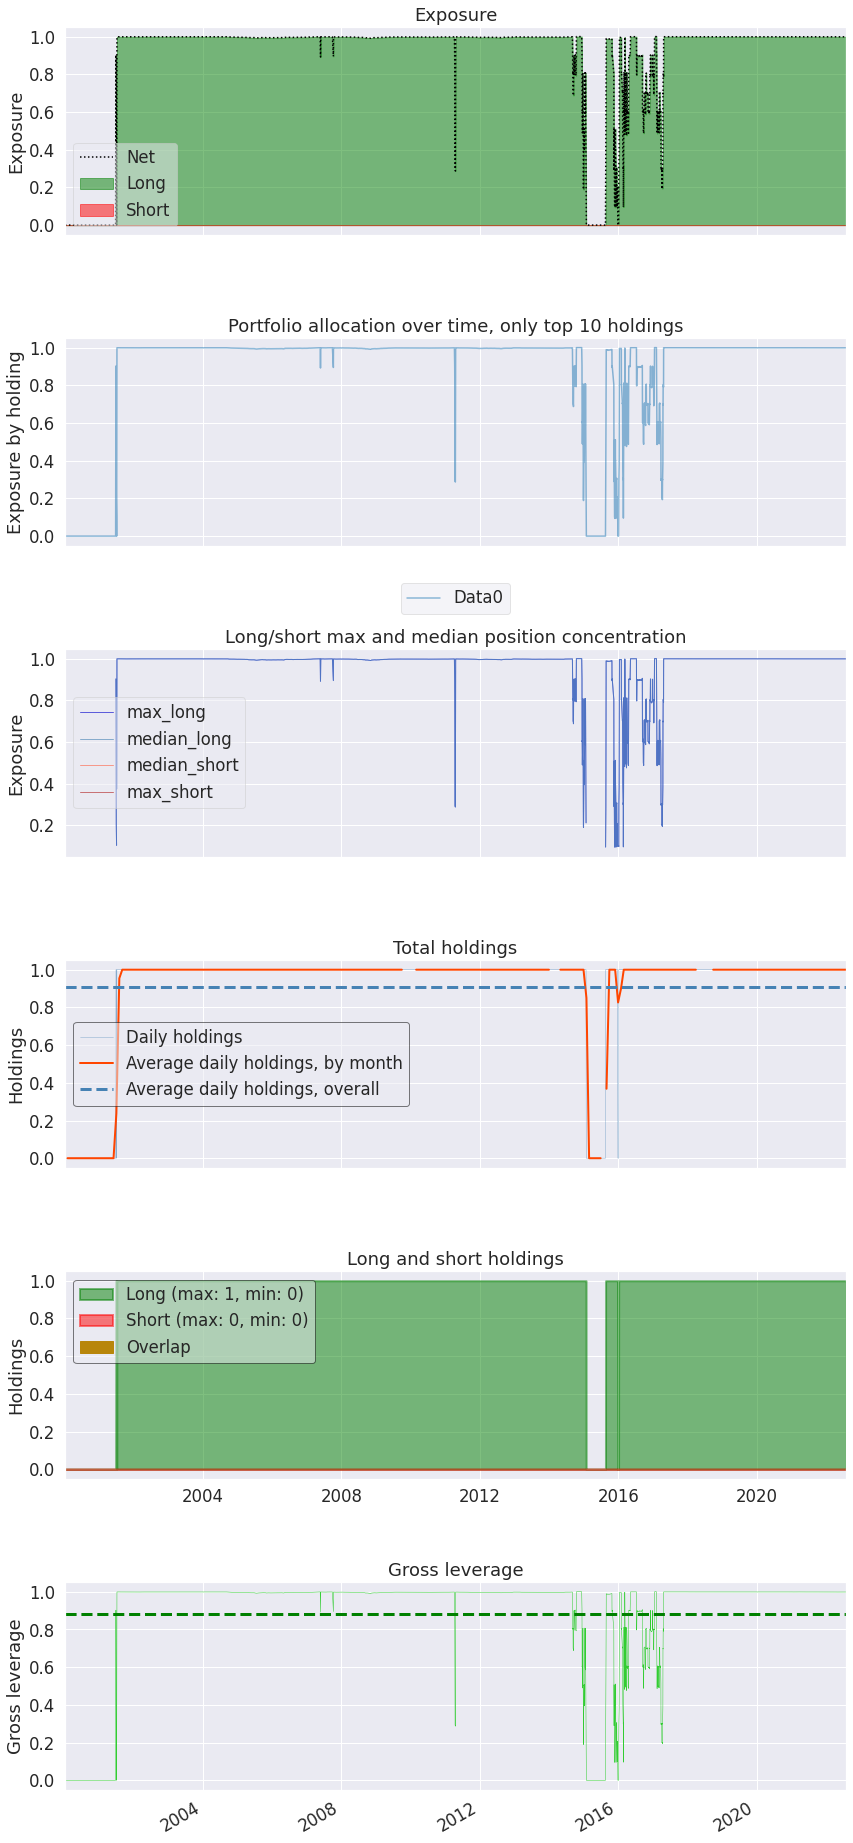

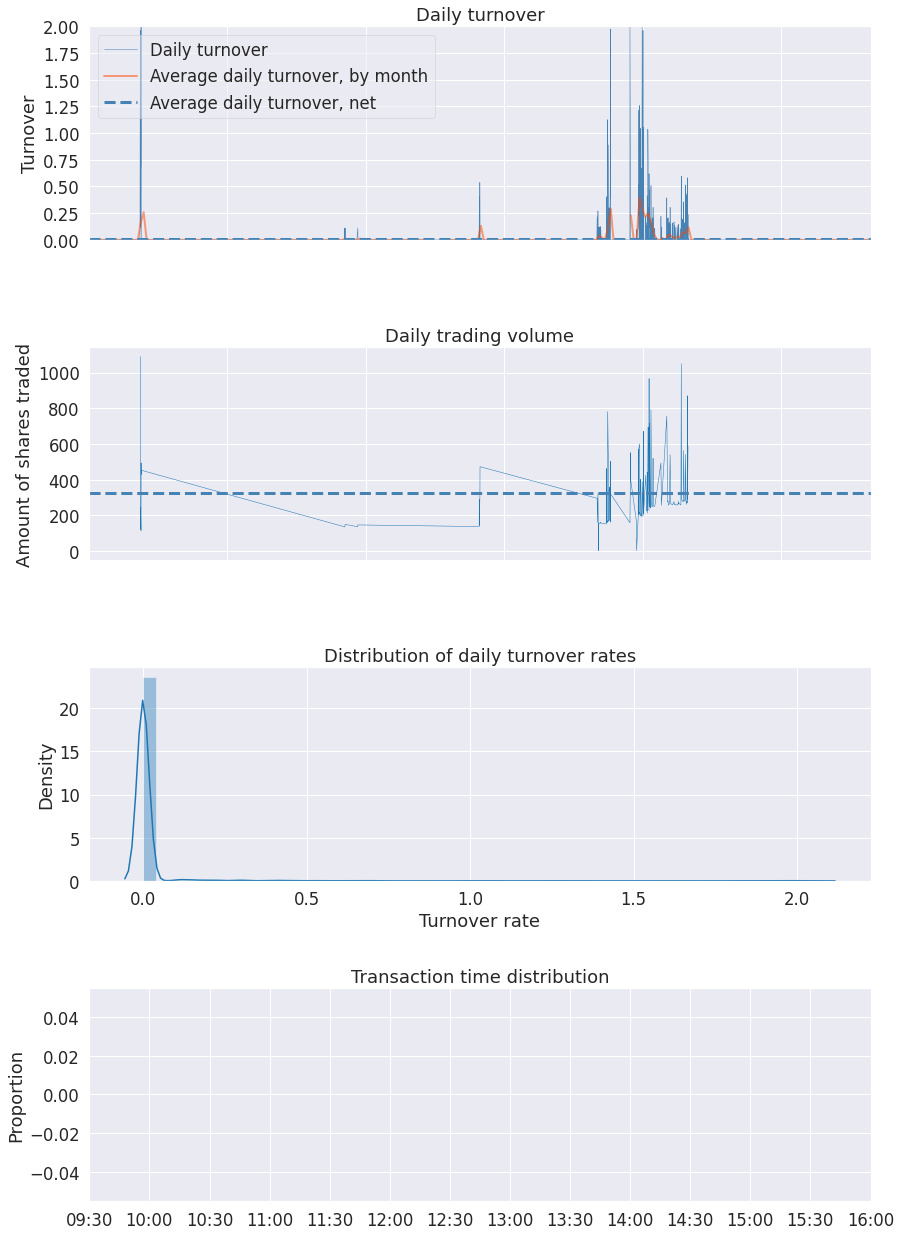

In [30]:
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    live_start_date='2018-01-01')